# Neural Machine Translation by Jointly Learning to Align and Translate [1]

## Summary, Implementation, and Experiment

# Summary

SMT (Statistical Machine Translation) 시스템이 지배적이던 기계 번역 (Machine Translation) 분야에서 점차 신경망 기계 번역 (Neural Machine Translation; NMT) 시스템이 떠오르기 시작했다. 여러 개의 하위 요소로 구성된 SMT 시스템과는 다르게, NMT 시스템은 문장을 읽고 이를 번역하는 하나의 큰 신경망만으로 이루어져 있다.

당시 대부분의 NMT 시스템은 인코더-디코더 (encoder-decoder) 형식을 보이고 있었는데, 이는 입력 시퀀스를 고정 길이의 벡터로 인코딩한 뒤 해당 벡터를 출력 시퀀스로 변환하는 방법이었다. 그러나 이와 같은 방식에서는 입력 시퀀스의 길이에 상관 없이 고정 길이의 벡터로 인코딩해야 하기 때문에 입력 시퀀스가 길어질수록 모델의 성능이 떨어진다는 문제점이 있었다.

해당 논문에서는 모델에 어텐션 메커니즘 (attention mechanism) 을 적용하여 문제점을 해결하고 NMT 시스템의 성능을 극적으로 향상하였다. 논문에서 제안한 모델의 디코더는 고정 길이의 벡터가 아닌, 벡터 리스트 중에서 매 동작마다 가장 관련 있는 입력 시퀀스 부분을 부드럽게 탐색하여 (soft-search) 요약 벡터를 생성한다.

이와 같은 모델은 고정 길이의 벡터에 정보를 압축할 필요가 없기 때문에 입력 시퀀스의 길이에 크게 제한받지 않는다. 또한 입력 시퀀스와 출력 시퀀스 사이의 배열 관계를 명시적으로 학습하기 때문에 시각화하여 확인할 수 있다.

해당 모델을 WMT’14 English to French Machine Translation 데이터셋으로 학습시켰을 때 당시 SMT 시스템의 최고점에 훨씬 가까워진 BLUE 점수를 받을 수 있었다. (28.45)



# Implementation

## Neural Network Modules

### GRU

GRU를 표현하는 기본적인 식은 다음과 같다:

$$
r_i = \sigma\big(W_r \cdot [x_{i-1}, h_{i-1}] + b_r\big), \\
z_i = \sigma\big(W_z \cdot [x_{i-1}, h_{i-1}] + b_z\big), \\
\tilde{h}_i = \tanh\big(W \cdot [x_{i-1}, r_i \circ h_{i-1}] + b\big), \\
h_i = (1-z_i) \circ h_{i-1} + z_i \circ \tilde{h}_{i-1}.
$$

이때 $\circ$ 은 하다마르 곱 (Hadamard product, element-wise product) 이다. 나아가 디코더 (decoder) 에 쓰이는 GRU의 경우 요약 벡터 (summary vector) $c_i$ (혹은 $c$) 도 연산에 사용하기 때문에 식이 달라진다.

$$
r_i = \sigma\big(W_r \cdot [x_{i-1}, h_{i-1}, c_i] + b_r\big), \\
z_i = \sigma\big(W_z \cdot [x_{i-1}, h_{i-1}, c_i] + b_z\big), \\
\tilde{h}_i = \tanh\big(W \cdot [x_{i-1}, r_i \circ h_{i-1}, c_i] + b\big), \\
h_i = (1-z_i) \circ h_{i-1} + z_i \circ \tilde{h}_{i-1}.
$$

### Encoder and Decoder


<table>
<tr>
  <td>
    <figure align="center">
      <img src="https://drive.google.com/uc?export=view&id=1JQxnWGlXKXNlGpATFbmipe-OPBmKPhhd" width=160 />
      <figcaption>Encoder</figcaption>
    </figure>
  </td>
  <td>
    <figure align="center">
      <img src="https://drive.google.com/uc?export=view&id=1BEGen7Y55p2TjCTTZCyvSK7Tf9WEYOwX" width=160 />
      <figcaption>Decoder</figcaption>
    </figure>
  </td>
</tr>
</table>

### NMT Network

<figure align="center">
  <img src="https://drive.google.com/uc?export=view&id=1fwFTSzQm0yqZD_rWsISIePdg4UDsUcyo" width=900 />
</figure>

## Build the Model and Train

In [1]:
# Download resources
from IPython.display import clear_output
!python -m spacy download en
!python -m spacy download de
!pip install torchdata
clear_output()

In [2]:
# Import libraries and setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import time
import matplotlib.pyplot as plt

from model import AttentionRNNNetwork
from utils import train_data, val_data, test_data, collate_fn, src_vocab, \
  trg_vocab, PAD_TOKEN, train, evaluate, format_time

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current device:', device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


Current device: cuda


In [3]:
# Set hyperparameters
BATCH_SIZE = 128

input_size = len(src_vocab)
output_size = len(trg_vocab)
padding_index = src_vocab.lookup_indices([PAD_TOKEN])[0]

EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_MAXOUTS = 0 # Not used
# DROPOUT =

NUM_EPOCHS = 10
# LEARNING_RATE =

In [4]:
# Create dataloader
train_dataloader = \
  DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
val_dataloader = \
  DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = \
  DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

print('Number of the training examples:', len(train_data))
print('Number of the validation examples:', len(val_data))
print('Number of the test examples:', len(test_data))

Number of the training examples: 29001
Number of the validation examples: 1015
Number of the test examples: 1000


In [5]:
def init_weights(model):
  for name, param in model.named_parameters(): # 바꾸어야함
    if 'weight' in name:
      nn.init.normal_(param.data, mean=0, std=0.01)
    else:
      nn.init.constant_(param.data, 0)
# Build the model
model = AttentionRNNNetwork(input_size, EMBED_SIZE, HIDDEN_SIZE, HIDDEN_SIZE, \
                  output_size, padding_index, NUM_MAXOUTS, device=device)
model.apply(init_weights)

print(model)
print(f'The number of model parameter: {sum([param.numel() for param in model.parameters()]):,}')

AttentionRNNNetwork(
  (encoder): BiRNNEncoder(
    (embedding): Embedding(7855, 256, padding_idx=1)
    (rnn): GRU(256, 512, bidirectional=True)
  )
  (decoder): AttentionRNNDecoder(
    (linear_hidden): Linear(in_features=512, out_features=512, bias=True)
    (embedding): Embedding(5894, 256, padding_idx=1)
    (attn): Attention(
      (linear_combined): Linear(in_features=1536, out_features=512, bias=True)
      (linear_attn): Linear(in_features=512, out_features=1, bias=False)
    )
    (rnn): GRU(1280, 512)
    (linear_pred): Linear(in_features=1792, out_features=5894, bias=True)
  )
)
The number of model parameter: 20,258,822


In [6]:
# Prepare an optimizer and a loss function
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss(ignore_index=padding_index)

In [7]:
# Train with evaluating regularly
best_val_loss = float('inf')
train_loss_history = []
val_loss_history = []
start_time = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
  print('-' * 41)
  print(f'Epoch {epoch}')
  print('-' * 41)

  train_loss_history += train(train_dataloader, model, optimizer, loss_fn, device, tf_ratio=0.5)
  val_loss, loss_history = evaluate(val_dataloader, model, loss_fn, device)
  val_loss_history += loss_history

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), f'best-model.pth')
  
  elapsed_time, total_time = format_time(start_time, time.time(), epoch / NUM_EPOCHS)
  print('-' * 41)
  print(f'End of epoch {epoch} ({elapsed_time}/{total_time})')
  print('-' * 41)
  print()
print('Done!')

-----------------------------------------
Epoch 1
-----------------------------------------
> [ 6528/29001] loss=6.0028, ppl=404.561
> [12928/29001] loss=5.0393, ppl=154.366
> [19328/29001] loss=4.7950, ppl=120.907
> [25728/29001] loss=4.6575, ppl=105.371
> [evaluation]  loss=5.0462, ppl=155.431
-----------------------------------------
End of epoch 1 ( 2m 56s/29m 20s)
-----------------------------------------

-----------------------------------------
Epoch 2
-----------------------------------------
> [ 6528/29001] loss=4.6007, ppl= 99.559
> [12928/29001] loss=4.3992, ppl= 81.388
> [19328/29001] loss=4.3481, ppl= 77.328
> [25728/29001] loss=4.3875, ppl= 80.435
> [evaluation]  loss=4.9629, ppl=143.007
-----------------------------------------
End of epoch 2 ( 5m 52s/29m 20s)
-----------------------------------------

-----------------------------------------
Epoch 3
-----------------------------------------
> [ 6528/29001] loss=4.4236, ppl= 83.397
> [12928/29001] loss=4.1817, ppl= 65.

# Experiment

## Performance Test

In [12]:
best_model = AttentionRNNNetwork(input_size, EMBED_SIZE, HIDDEN_SIZE, HIDDEN_SIZE, \
                  output_size, padding_index, NUM_MAXOUTS, device=device)
best_model.load_state_dict(torch.load('best-model.pth'))

<All keys matched successfully>

In [13]:
_ = evaluate(test_dataloader, best_model, loss_fn, device)

> [evaluation]  loss=3.9457, ppl= 51.710


## Translation Examples

In [29]:
# Translate some samples from the training dataset
from utils import PAD_TOKEN, SOS_TOKEN, EOS_TOKEN
BATCH_SIZE = 5
newtrain_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
src_specials = src_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
trg_specials = trg_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])

best_model.eval()
with torch.no_grad():
  for batch, (src, trg) in enumerate(newtrain_dataloader):
    src, trg = src.to(device), trg.to(device)
    pred, _ = best_model(src, trg) # pred: [max_seq_len, batch_size, output_size]

    # src_sentences = [[src[j, i] for j in range(src.size(0)) if src[j, i] not in src_specials] for i in range(BATCH_SIZE)]
    src_sentences = [[src[j, i] for j in range(src.size(0))] for i in range(BATCH_SIZE)]
    src_sentences = [src_vocab.lookup_tokens(sentence) for sentence in src_sentences] # reversed!
    src_sentences = [' '.join(sentence) for sentence in src_sentences] # reversed!

    # trg_sentences = [[trg[j, i] for j in range(trg.size(0)) if trg[j, i] not in trg_specials] for i in range(BATCH_SIZE)]
    trg_sentences = [[trg[j, i] for j in range(trg.size(0))] for i in range(BATCH_SIZE)]
    trg_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in trg_sentences]
    trg_sentences = [' '.join(sentence) for sentence in trg_sentences]

    # pred_sentences = [[pred[j, i, :].argmax() for j in range(pred.size(0)) if pred[j, i, :].argmax() not in trg_specials] for i in range(BATCH_SIZE)]
    pred_sentences = [[pred[j, i, :].argmax() for j in range(pred.size(0))] for i in range(BATCH_SIZE)]
    pred_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in pred_sentences]
    pred_sentences = [' '.join(sentence) for sentence in pred_sentences]

    for src, trg, pred in zip(src_sentences, trg_sentences, pred_sentences):
      print('Input German:     ', src)
      print('Target English:   ', trg)
      print('Predicted English:', pred)
      print()
    
    if batch > 2: break

Input German:      <sos> zwei junge weiße männer sind im freien in der nähe vieler büsche . <eos> <pad> <pad>
Target English:    <sos> two young , white males are outside near many bushes . <eos> <pad> <pad> <pad> <pad>
Predicted English: <unk> white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white

Input German:      <sos> mehrere männer mit schutzhelmen bedienen ein <unk> . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Target English:    <sos> several men in hard hats are operating a giant pulley system . <eos> <pad> <pad> <pad>
Predicted English: <unk> men wearing dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark dark 

In [26]:
# Translate some samples from the test dataset
BATCH_SIZE = 5
newtest_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
src_specials = src_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
trg_specials = trg_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])

best_model.eval()
with torch.no_grad():
  for batch, (src, trg) in enumerate(newtest_dataloader):
    src, trg = src.to(device), trg.to(device)
    pred, _ = best_model(src, trg) # pred: [max_seq_len, batch_size, output_size]

    src_sentences = [[src[j, i] for j in range(src.size(0)) if src[j, i] not in src_specials] for i in range(BATCH_SIZE)]
    src_sentences = [src_vocab.lookup_tokens(sentence[::-1]) for sentence in src_sentences] # reversed!
    src_sentences = [' '.join(sentence) for sentence in src_sentences] # reversed!

    trg_sentences = [[trg[j, i] for j in range(trg.size(0)) if trg[j, i] not in trg_specials] for i in range(BATCH_SIZE)]
    trg_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in trg_sentences]
    trg_sentences = [' '.join(sentence) for sentence in trg_sentences]

    pred_sentences = [[pred[j, i, :].argmax() for j in range(pred.size(0)) if pred[j, i, :].argmax() not in trg_specials] for i in range(BATCH_SIZE)]
    pred_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in pred_sentences]
    pred_sentences = [' '.join(sentence) for sentence in pred_sentences]

    for src, trg, pred in zip(src_sentences, trg_sentences, pred_sentences):
      print('Input German:     ', src)
      print('Target English:   ', trg)
      print('Predicted English:', pred)
      print()
      
    if batch > 2: break

Input German:      . <unk> etwas der , hut orangefarbenen einem mit mann ein
Target English:    a man in an orange hat starring at something .
Predicted English: <unk> man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man man

Input German:      . zaun weißen einem vor gras <unk> über läuft terrier boston ein
Target English:    a boston terrier is running on lush green grass in front of a white fence .
Predicted English: <unk> white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white white

Input German:      . tritt einem mit stock einen bricht karateanzug einem in mädchen ein
Target English:    a girl in karate uniform bre

## Visualize Attention Scores

In [34]:
# Translate some samples from the training dataset
BATCH_SIZE = 5
newtrain_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
src_specials = src_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
trg_specials = trg_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])

best_model.eval()
with torch.no_grad():
  for batch, (src, trg) in enumerate(newtrain_dataloader):
    src, trg = src.to(device), trg.to(device)
    pred, attns = best_model(src, trg) # pred: [max_seq_len, batch_size, output_size]

    src_sentences = [[src[j, i] for j in range(src.size(0))] for i in range(BATCH_SIZE)]
    src_sentences = [src_vocab.lookup_tokens(sentence) for sentence in src_sentences]
    # src_sentences = [' '.join(sentence) for sentence in src_sentences]

    trg_sentences = [[trg[j, i] for j in range(trg.size(0))] for i in range(BATCH_SIZE)]
    trg_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in trg_sentences]
    # trg_sentences = [' '.join(sentence) for sentence in trg_sentences]

    pred_sentences = [[pred[j, i, :].argmax() for j in range(pred.size(0))] for i in range(BATCH_SIZE)]
    pred_sentences = [trg_vocab.lookup_tokens(sentence) for sentence in pred_sentences]
    # pred_sentences = [' '.join(sentence) for sentence in pred_sentences]

    break

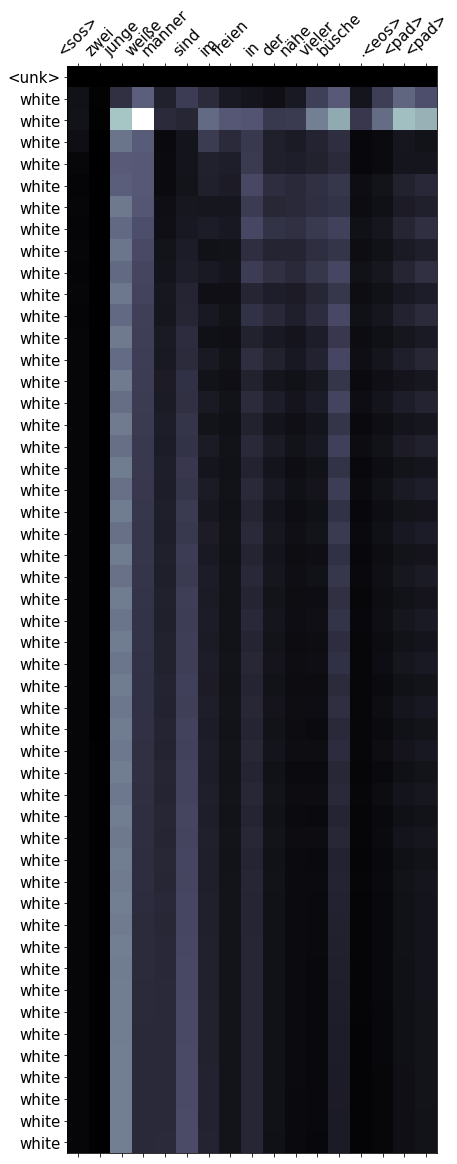

In [35]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

attns = attns[:, :, 0].cpu().detach().numpy() # (trg_len, src_len)
cax = ax.matshow(attns, cmap='bone')

ax.tick_params(labelsize=15)
x_ticks = [''] + src_sentences[0]
y_ticks = [''] + pred_sentences[0]
ax.set_xticklabels(x_ticks, rotation=45)
ax.set_yticklabels(y_ticks)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [64]:
# Translate some samples from the training dataset
BATCH_SIZE = 1
newtrain_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
src_specials = src_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])
trg_specials = trg_vocab([PAD_TOKEN, SOS_TOKEN, EOS_TOKEN])

best_model.eval()
with torch.no_grad():
  for batch, (src, trg) in enumerate(newtrain_dataloader):
    src, trg = src.to(device), trg.to(device)
    src, trg = src.squeeze(1), trg.squeeze(1)
    pred, _ = best_model(src, trg) # pred: [max_seq_len, batch_size, output_size]

    print(pred.shape)
    values, indices = pred.cpu().exp().max(dim=1)
    print(values.tolist())
    print(indices.tolist())

    break

torch.Size([50, 5894])
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]


# References

[1] Neural Machine Translation by Jointly Learning to Align and Translate [[link]](https://doi.org/10.48550/arXiv.1409.0473)